In [32]:
import os 
import cv2
import matplotlib.pyplot as plt

### IOU Calculation

In [72]:
def IOU( boxA ,boxB ):
    
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [73]:
def full_overlap(proposedRect , gtBox):
    (propStartX, propStartY, propEndX, propEndY) = proposedRect
    (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox
    
    fullOverlap = propStartX >= gtStartX
    fullOverlap = fullOverlap and propStartY >= gtStartY
    fullOverlap = fullOverlap and propEndX <= gtEndX
    fullOverlap = fullOverlap and propEndY <= gtEndY
    
    return fullOverlap

In [81]:
def check_bbox(filename , gt , prop):
    iou_scr = IOU([40, 104, 309, 305],[136, 0, 313, 105])
    print(iou_scr)
    
    img = cv2.imread(filename)
    
    image = cv2.rectangle(img, (gt[0],gt[1]), (gt[2],gt[3]), (255,0,0), 2)
    image = cv2.rectangle(img, (prop[0],prop[1]), (prop[2],prop[3]), (0,255,0), 2)
    
    plt.imshow(image)

### Dataset Creation 

In [106]:
def get_cadidate_boxes(gbox , img):
    
    W,H,_ = img.shape
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    proposals = []
    
    for x,y,w,h in rects:
        if w / float(W) < 0.1 or h / float(H) < 0.1:
            continue
            
        proposals.append( [x , y , x+w , y+h] )
    
    positive_boxes = []
    negative_boxes = []
    
    pos = 0
    neg = 0
    
    for i in proposals:
        
        iou_score = IOU(i , gbox)
        
        if iou_score > 0.7:
            if pos<1:
                print('\t\t Pos Box : ' + ', '.join(str(ele) for ele in i))
                positive_boxes.append(i)
                pos+=1

        elif iou_score < 0.4:
            
            flag = full_overlap(i , gbox)
            
            if neg<1 and flag == False:
                print('\t\t Neg Box : ' + ', '.join(str(ele) for ele in i))
                negative_boxes.append(i)
                neg+=1

    return positive_boxes , negative_boxes
            

In [107]:
def create_dataset(boxes , class_name , img , count):
    temp = count
    for i in boxes:
        xmin ,ymin , xmax ,ymax = i
        
        roi = img[ ymin:ymax, xmin:xmax]
        roi = cv2.resize(roi, (150,150) ,interpolation=cv2.INTER_CUBIC)
        
        cv2.imwrite('../Dataset/'+class_name+'/'+str(temp)+'.jpg', roi)
        temp += 1
        
    
    return temp

In [108]:
def create_class(filename):
    
    f = open('../Raw_images/'+filename)
    class_name = filename.split('_')[0]
    
    lines = f.readlines()
    
    neg_count = 0
    pos_count = 0
    
    img_count = 0
    
    for i in lines:
        img_name ,xmin , ymin , xmax , ymax  = i.split()
        print(str(img_count) +  ' : ' + img_name)
        img_count += 1
        
        img = cv2.imread('../Raw_images/' + class_name + '/' + img_name + '.jpg')
        gbox = [int(xmin) , int(ymin) ,int(xmax) , int(ymax)]
        
        print('\t\t GT Box : ' + ', '.join(str(ele) for ele in gbox))
        
        pos_box , neg_box = get_cadidate_boxes(gbox ,img)
        
        pos_count = create_dataset(pos_box ,class_name , img ,pos_count)
        neg_count = create_dataset(neg_box ,'neg' , img ,neg_count)
        
        roi = img[ int(ymin):int(ymax), int(xmin):int(xmax)]

In [112]:
create_class('bird_bbox.txt')

0 : Acadian_Flycatcher_0002_2879202801
		 GT Box : 40, 104, 309, 305
		 Neg Box : 244, 240, 315, 318
		 Pos Box : 0, 128, 318, 318
1 : Acadian_Flycatcher_0026_2511706172
		 GT Box : 154, 116, 457, 361
		 Neg Box : 0, 384, 64, 478
		 Pos Box : 157, 127, 463, 355
2 : Acadian_Flycatcher_0031_505034909
		 GT Box : 103, 57, 486, 323
		 Pos Box : 112, 72, 459, 356
		 Neg Box : 215, 295, 255, 356
3 : American_Crow_0013_3051549869
		 GT Box : 104, 103, 489, 394
		 Neg Box : 10, 10, 147, 98
		 Pos Box : 109, 109, 478, 393
4 : American_Crow_0018_1877680209
		 GT Box : 35, 20, 468, 328
		 Neg Box : 376, 117, 454, 329
		 Pos Box : 35, 25, 448, 329
5 : American_Crow_0023_xxx
		 GT Box : 71, 102, 438, 253
		 Neg Box : 295, 11, 421, 120
		 Pos Box : 99, 109, 417, 236
6 : American_Goldfinch_0005_191903025
		 GT Box : 187, 33, 390, 284
		 Neg Box : 439, 200, 500, 312
		 Pos Box : 199, 41, 381, 276
7 : American_Goldfinch_0008_135699561
		 GT Box : 251, 55, 415, 262
		 Pos Box : 260, 65, 406, 252
		 Neg 

		 Neg Box : 380, 61, 500, 327
		 Pos Box : 56, 25, 377, 373
66 : Blue_Grosbeak_0002_2452092354
		 GT Box : 36, 88, 381, 394
		 Neg Box : 184, 420, 338, 475
		 Pos Box : 19, 100, 377, 402
67 : Blue_Grosbeak_0008_2450854752
		 GT Box : 39, 115, 357, 466
		 Neg Box : 0, 437, 435, 500
		 Pos Box : 47, 123, 354, 458
68 : Blue_Grosbeak_0027_152633616
		 GT Box : 160, 161, 324, 439
		 Neg Box : 0, 284, 224, 500
		 Pos Box : 157, 167, 312, 400
69 : Blue_Jay_0004_2593314041
		 GT Box : 62, 22, 419, 298
		 Neg Box : 158, 17, 307, 90
		 Pos Box : 17, 17, 483, 297
70 : Blue_Jay_0024_3008742747
		 GT Box : 2, 79, 336, 243
		 Neg Box : 246, 0, 305, 65
		 Pos Box : 19, 90, 317, 226
71 : Blue_Jay_0030_2979521195
		 GT Box : 2, 26, 372, 336
		 Neg Box : 269, 0, 500, 171
		 Pos Box : 0, 0, 370, 346
72 : Blue_headed_Vireo_0001_3057218592
		 GT Box : 129, 132, 358, 421
		 Neg Box : 212, 390, 307, 500
		 Pos Box : 136, 135, 369, 417
73 : Blue_headed_Vireo_0008_2372359048
		 GT Box : 71, 70, 282, 451
		 Ne

		 Neg Box : 328, 388, 378, 448
		 Pos Box : 0, 0, 409, 448
133 : Cedar_Waxwing_0012_381146020
		 GT Box : 116, 25, 340, 431
		 Neg Box : 350, 229, 400, 281
134 : Cedar_Waxwing_0031_169328599
		 GT Box : 79, 69, 345, 384
		 Neg Box : 126, 0, 209, 173
		 Pos Box : 111, 0, 334, 385
135 : Cerulean_Warbler_0006_xxx
		 GT Box : 54, 61, 439, 284
		 Neg Box : 126, 281, 175, 344
		 Pos Box : 71, 81, 414, 290
136 : Cerulean_Warbler_0011_69462946
		 GT Box : 139, 101, 268, 303
		 Neg Box : 119, 260, 180, 375
		 Pos Box : 152, 111, 267, 347
137 : Cerulean_Warbler_0022_2658928684
		 GT Box : 208, 97, 414, 203
		 Neg Box : 290, 25, 372, 78
		 Pos Box : 209, 97, 413, 208
138 : Chestnut_sided_Warbler_0015_2523239162
		 GT Box : 174, 16, 349, 332
		 Neg Box : 0, 222, 69, 333
		 Pos Box : 175, 38, 331, 292
139 : Chestnut_sided_Warbler_0018_1755798667
		 GT Box : 30, 65, 378, 281
		 Neg Box : 0, 199, 76, 246
		 Pos Box : 33, 75, 332, 276
140 : Chestnut_sided_Warbler_0020_2492580874
		 GT Box : 2, 63, 40

		 Neg Box : 0, 166, 213, 235
		 Pos Box : 181, 71, 500, 268
199 : Forsters_Tern_0007_308527199
		 GT Box : 120, 112, 360, 273
		 Neg Box : 281, 190, 500, 254
		 Pos Box : 98, 119, 352, 266
200 : Forsters_Tern_0014_2803159992
		 GT Box : 139, 109, 364, 264
		 Neg Box : 33, 282, 117, 333
		 Pos Box : 183, 117, 359, 258
201 : Fox_Sparrow_0002_3059583792
		 GT Box : 2, 53, 439, 399
		 Neg Box : 54, 0, 211, 63
		 Pos Box : 0, 0, 500, 400
202 : Fox_Sparrow_0017_67178485
		 GT Box : 96, 161, 339, 273
		 Neg Box : 228, 283, 492, 351
		 Pos Box : 102, 154, 327, 278
203 : Fox_Sparrow_0026_2210097193
		 GT Box : 53, 51, 322, 325
		 Neg Box : 37, 113, 81, 236
		 Pos Box : 64, 58, 298, 284
204 : Frigatebird_0003_1478659470
		 GT Box : 38, 63, 417, 301
		 Neg Box : 65, 228, 224, 333
		 Pos Box : 86, 72, 423, 277
205 : Frigatebird_0006_663848739
		 GT Box : 5, 83, 444, 281
		 Neg Box : 119, 0, 500, 121
		 Pos Box : 50, 86, 438, 277
206 : Frigatebird_0014_662444879
		 GT Box : 2, 36, 388, 499
		 Neg 

		 Neg Box : 387, 314, 466, 373
		 Pos Box : 71, 35, 406, 329
265 : Hooded_Merganser_0012_2224465206
		 GT Box : 142, 86, 356, 192
		 Neg Box : 249, 235, 486, 349
		 Pos Box : 154, 92, 351, 181
266 : Hooded_Merganser_0025_2142693462
		 GT Box : 85, 128, 384, 270
		 Neg Box : 0, 0, 500, 403
		 Pos Box : 83, 136, 383, 294
267 : Hooded_Oriole_0018_967535064
		 GT Box : 162, 58, 488, 180
		 Neg Box : 421, 216, 478, 269
268 : Hooded_Oriole_0026_763249491
		 GT Box : 29, 63, 408, 222
		 Neg Box : 401, 0, 500, 112
		 Pos Box : 27, 61, 406, 245
269 : Hooded_Oriole_0028_212491548
		 GT Box : 167, 97, 391, 255
		 Neg Box : 124, 293, 292, 365
		 Pos Box : 169, 99, 354, 280
270 : Hooded_Warbler_0002_2499838711
		 GT Box : 210, 126, 358, 239
		 Neg Box : 0, 128, 500, 357
		 Pos Box : 212, 90, 356, 241
271 : Hooded_Warbler_0009_67483709
		 GT Box : 148, 121, 270, 184
		 Neg Box : 157, 0, 242, 183
272 : Hooded_Warbler_0026_2817738193
		 GT Box : 122, 91, 434, 249
		 Neg Box : 12, 12, 87, 351
273 : Ho

		 Neg Box : 318, 189, 500, 335
		 Pos Box : 0, 0, 500, 335
333 : Mangrove_Cuckoo_0017_2191601733
		 GT Box : 148, 40, 349, 325
		 Neg Box : 285, 0, 500, 258
		 Pos Box : 129, 48, 353, 310
334 : Mangrove_Cuckoo_0018_2191601669
		 GT Box : 125, 76, 249, 441
		 Neg Box : 251, 107, 334, 197
335 : Mangrove_Cuckoo_0022_2226598074
		 GT Box : 176, 109, 344, 374
		 Neg Box : 339, 0, 377, 82
		 Pos Box : 160, 99, 336, 375
336 : Marsh_Wren_0013_2504213513
		 GT Box : 120, 68, 367, 328
		 Neg Box : 170, 19, 245, 243
		 Pos Box : 115, 0, 362, 334
337 : Marsh_Wren_0024_53824775
		 GT Box : 191, 201, 327, 391
		 Neg Box : 0, 0, 148, 500
338 : Marsh_Wren_0030_2068994674
		 GT Box : 175, 104, 413, 272
		 Neg Box : 310, 255, 414, 386
339 : Mockingbird_0012_348046755
		 GT Box : 139, 98, 445, 327
		 Neg Box : 248, 249, 471, 333
		 Pos Box : 151, 107, 448, 318
340 : Mockingbird_0019_337873228
		 GT Box : 51, 57, 277, 499
		 Neg Box : 272, 273, 333, 373
		 Pos Box : 0, 91, 279, 491
341 : Mockingbird_0024

		 Neg Box : 73, 0, 228, 51
400 : Pied_billed_Grebe_0015_2217349790
		 GT Box : 109, 77, 476, 239
		 Neg Box : 51, 263, 331, 400
		 Pos Box : 114, 74, 477, 265
401 : Pied_billed_Grebe_0028_674298766
		 GT Box : 102, 105, 314, 253
		 Neg Box : 216, 232, 287, 304
		 Pos Box : 102, 114, 312, 257
402 : Pigeon_Guillemot_0007_2477632639
		 GT Box : 169, 98, 345, 171
		 Neg Box : 164, 143, 482, 198
		 Pos Box : 179, 99, 390, 168
403 : Pigeon_Guillemot_0015_2699753946
		 GT Box : 186, 95, 296, 274
		 Neg Box : 0, 12, 163, 152
404 : Pigeon_Guillemot_0023_915489249
		 GT Box : 118, 96, 424, 467
		 Neg Box : 262, 432, 340, 483
		 Pos Box : 138, 108, 386, 461
405 : Pileated_Woodpecker_0006_2443246132
		 GT Box : 179, 38, 434, 471
		 Neg Box : 36, 218, 123, 500
		 Pos Box : 186, 0, 406, 500
406 : Pileated_Woodpecker_0013_2120896468
		 GT Box : 13, 211, 275, 357
		 Neg Box : 102, 351, 197, 386
		 Pos Box : 17, 214, 333, 360
407 : Pileated_Woodpecker_0036_25993104
		 GT Box : 46, 20, 451, 358
		 Pos 

		 Neg Box : 319, 215, 414, 297
		 Pos Box : 0, 0, 335, 371
465 : Ruby_throated_Hummingbird_0011_2595812723
		 GT Box : 126, 38, 444, 299
		 Neg Box : 293, 86, 445, 304
		 Pos Box : 176, 59, 432, 290
466 : Ruby_throated_Hummingbird_0018_2725343851
		 GT Box : 356, 139, 486, 242
		 Neg Box : 92, 161, 135, 220
		 Pos Box : 337, 142, 490, 236
467 : Ruby_throated_Hummingbird_0022_156185295
		 GT Box : 292, 195, 405, 390
		 Neg Box : 3, 182, 154, 244
		 Pos Box : 285, 219, 396, 384
468 : Rufous_Hummingbird_0004_2472798444
		 GT Box : 5, 93, 311, 429
		 Neg Box : 250, 274, 304, 444
		 Pos Box : 45, 95, 333, 444
469 : Rufous_Hummingbird_0027_169289992
		 GT Box : 77, 198, 411, 484
		 Neg Box : 231, 0, 362, 127
		 Pos Box : 80, 208, 326, 480
470 : Rufous_Hummingbird_0033_2523552268
		 GT Box : 48, 114, 293, 384
		 Neg Box : 200, 447, 264, 500
		 Pos Box : 0, 122, 288, 405
471 : Rusty_Blackbird_0004_1848793704
		 GT Box : 2, 111, 449, 428
		 Neg Box : 0, 0, 133, 124
		 Pos Box : 98, 117, 439, 4

		 Neg Box : 374, 309, 482, 377
		 Pos Box : 146, 129, 341, 346
532 : Vesper_Sparrow_0014_2929246967
		 GT Box : 179, 122, 275, 253
		 Neg Box : 55, 320, 108, 380
		 Pos Box : 175, 119, 269, 240
533 : Vesper_Sparrow_0034_59200319
		 GT Box : 113, 47, 442, 352
		 Neg Box : 439, 349, 500, 409
		 Pos Box : 79, 66, 500, 346
534 : Warbling_Vireo_0004_59215684
		 GT Box : 271, 33, 484, 203
		 Neg Box : 258, 1, 390, 132
		 Pos Box : 282, 1, 500, 211
535 : Warbling_Vireo_0025_2500358564
		 GT Box : 102, 97, 332, 344
		 Neg Box : 0, 272, 260, 341
		 Pos Box : 85, 76, 313, 319
536 : Warbling_Vireo_0029_2838167774
		 GT Box : 171, 192, 301, 279
		 Neg Box : 249, 0, 500, 104
		 Pos Box : 179, 200, 313, 286
537 : Western_Grebe_0005_327612045
		 GT Box : 12, 51, 454, 332
		 Neg Box : 0, 181, 360, 244
		 Pos Box : 0, 76, 464, 398
538 : Western_Grebe_0023_2845035814
		 GT Box : 109, 61, 457, 228
		 Neg Box : 0, 0, 500, 108
		 Pos Box : 127, 88, 454, 226
539 : Western_Grebe_0024_2459546646
		 GT Box : 

		 Neg Box : 0, 215, 182, 375
		 Pos Box : 130, 71, 386, 375
596 : Yellow_headed_Blackbird_0027_2052282414
		 GT Box : 194, 93, 392, 261
		 Neg Box : 74, 194, 109, 250
		 Pos Box : 228, 107, 384, 258
597 : Yellow_throated_Vireo_0007_147252880
		 GT Box : 256, 136, 403, 241
		 Neg Box : 0, 227, 83, 370
598 : Yellow_throated_Vireo_0010_1403836833
		 GT Box : 42, 114, 388, 332
		 Neg Box : 5, 421, 102, 500
		 Pos Box : 0, 130, 396, 334
599 : Yellow_throated_Vireo_0017_2490159421
		 GT Box : 115, 101, 398, 379
		 Neg Box : 176, 348, 323, 500
		 Pos Box : 135, 111, 382, 361


In [115]:
create_class('car_bbox.txt')

0 : 00001
		 GT Box : 26, 116, 379, 375
		 Neg Box : 308, 122, 400, 172
		 Pos Box : 32, 150, 358, 360
1 : 00002
		 GT Box : 16, 69, 386, 348
		 Neg Box : 0, 136, 105, 226
		 Pos Box : 0, 87, 390, 372
2 : 00003
		 GT Box : 53, 91, 376, 318
		 Neg Box : 269, 59, 321, 115
		 Pos Box : 57, 146, 373, 315
3 : 00004
		 GT Box : 118, 113, 283, 316
		 Neg Box : 0, 0, 400, 400
		 Pos Box : 109, 108, 291, 336
4 : 00005
		 GT Box : 39, 133, 369, 367
		 Neg Box : 66, 0, 400, 129
		 Pos Box : 0, 133, 400, 400
5 : 00006
		 GT Box : 180, 268, 358, 386
		 Neg Box : 126, 0, 248, 46
		 Pos Box : 156, 271, 359, 391
6 : 00007
		 GT Box : 55, 67, 338, 331
		 Neg Box : 356, 36, 400, 96
		 Pos Box : 52, 120, 332, 317
7 : 00008
		 GT Box : 46, 66, 370, 342
		 Neg Box : 0, 0, 274, 119
		 Pos Box : 98, 70, 370, 323
8 : 00009
		 GT Box : 6, 60, 397, 366
		 Neg Box : 307, 0, 400, 86
		 Pos Box : 0, 81, 400, 400
9 : 00010
		 GT Box : 13, 92, 389, 306
		 Neg Box : 299, 104, 400, 215
		 Pos Box : 0, 94, 400, 308
10 

		 Neg Box : 0, 0, 227, 180
		 Pos Box : 65, 132, 400, 358
83 : 00084
		 GT Box : 17, 56, 388, 395
		 Neg Box : 85, 0, 204, 40
		 Pos Box : 0, 0, 400, 400
84 : 00085
		 GT Box : 9, 67, 393, 335
		 Neg Box : 99, 0, 229, 67
		 Pos Box : 16, 116, 390, 336
85 : 00086
		 GT Box : 32, 130, 378, 379
		 Neg Box : 186, 33, 400, 140
		 Pos Box : 33, 141, 374, 319
86 : 00087
		 GT Box : 15, 62, 390, 368
		 Neg Box : 0, 0, 400, 150
		 Pos Box : 0, 0, 400, 359
87 : 00088
		 GT Box : 26, 36, 366, 360
		 Neg Box : 71, 0, 159, 70
		 Pos Box : 45, 44, 400, 400
88 : 00089
		 GT Box : 19, 102, 392, 321
		 Neg Box : 0, 0, 400, 68
		 Pos Box : 45, 117, 400, 291
89 : 00090
		 GT Box : 7, 76, 395, 375
		 Neg Box : 296, 17, 337, 78
		 Pos Box : 0, 132, 400, 400
90 : 00091
		 GT Box : 31, 48, 309, 349
		 Neg Box : 242, 8, 348, 77
		 Pos Box : 0, 62, 320, 400
91 : 00092
		 GT Box : 67, 99, 328, 322
		 Neg Box : 0, 198, 400, 400
		 Pos Box : 95, 97, 325, 309
92 : 00093
		 GT Box : 33, 116, 375, 315
		 Neg Box : 

		 Neg Box : 278, 0, 337, 80
		 Pos Box : 0, 165, 400, 400
165 : 00166
		 GT Box : 4, 77, 379, 272
		 Neg Box : 0, 138, 43, 240
		 Pos Box : 0, 61, 387, 279
166 : 00167
		 GT Box : 17, 39, 390, 375
		 Neg Box : 0, 35, 101, 239
		 Pos Box : 15, 41, 370, 324
167 : 00168
		 GT Box : 69, 80, 353, 324
		 Neg Box : 315, 30, 400, 139
		 Pos Box : 72, 93, 307, 357
168 : 00169
		 GT Box : 6, 85, 400, 312
		 Neg Box : 0, 0, 400, 191
		 Pos Box : 9, 98, 390, 277
169 : 00170
		 GT Box : 30, 59, 384, 378
		 Neg Box : 308, 326, 400, 400
		 Pos Box : 0, 0, 400, 400
170 : 00171
		 GT Box : 55, 92, 349, 372
		 Neg Box : 320, 289, 400, 369
		 Pos Box : 57, 97, 341, 312
171 : 00172
		 GT Box : 5, 142, 394, 350
		 Neg Box : 60, 0, 135, 127
		 Pos Box : 0, 142, 400, 349
172 : 00173
		 GT Box : 20, 61, 383, 344
		 Neg Box : 14, 80, 176, 267
		 Pos Box : 17, 125, 376, 350
173 : 00174
		 GT Box : 20, 60, 385, 328
		 Neg Box : 71, 24, 186, 75
		 Pos Box : 0, 71, 380, 376
174 : 00175
		 GT Box : 34, 90, 370, 37

		 Neg Box : 103, 47, 172, 95
		 Pos Box : 21, 80, 369, 321
247 : 00248
		 GT Box : 35, 150, 342, 348
		 Neg Box : 283, 112, 400, 250
		 Pos Box : 25, 161, 334, 339
248 : 00249
		 GT Box : 4, 129, 394, 375
		 Neg Box : 21, 106, 248, 148
		 Pos Box : 6, 152, 391, 352
249 : 00250
		 GT Box : 17, 72, 380, 384
		 Neg Box : 99, 55, 205, 139
		 Pos Box : 47, 72, 372, 342
250 : 00251
		 GT Box : 71, 76, 367, 319
		 Neg Box : 248, 217, 400, 374
		 Pos Box : 52, 58, 331, 337
251 : 00252
		 GT Box : 54, 109, 368, 345
		 Neg Box : 345, 227, 400, 329
		 Pos Box : 56, 138, 400, 359
252 : 00253
		 GT Box : 32, 88, 362, 279
		 Neg Box : 204, 40, 341, 164
		 Pos Box : 0, 95, 358, 284
253 : 00254
		 GT Box : 28, 27, 395, 350
		 Neg Box : 0, 186, 371, 400
		 Pos Box : 0, 40, 366, 348
254 : 00255
		 GT Box : 15, 74, 371, 375
		 Neg Box : 141, 324, 258, 379
		 Pos Box : 0, 77, 374, 355
255 : 00256
		 GT Box : 34, 143, 315, 339
		 Neg Box : 160, 208, 400, 376
		 Pos Box : 32, 189, 305, 339
256 : 00257
		 G

		 Neg Box : 293, 241, 341, 319
		 Pos Box : 0, 101, 326, 353
328 : 00329
		 GT Box : 6, 84, 377, 380
		 Neg Box : 0, 168, 42, 265
		 Pos Box : 28, 88, 374, 379
329 : 00330
		 GT Box : 134, 111, 266, 366
		 Neg Box : 49, 112, 225, 218
		 Pos Box : 138, 106, 261, 314
330 : 00331
		 GT Box : 16, 68, 372, 326
		 Neg Box : 240, 17, 311, 72
		 Pos Box : 16, 118, 400, 330
331 : 00332
		 GT Box : 46, 249, 240, 400
		 Neg Box : 0, 0, 100, 173
		 Pos Box : 51, 251, 234, 400
332 : 00333
		 GT Box : 24, 124, 378, 357
		 Neg Box : 320, 327, 400, 380
		 Pos Box : 0, 127, 400, 400
333 : 00334
		 GT Box : 50, 133, 390, 397
		 Neg Box : 339, 194, 400, 246
		 Pos Box : 0, 158, 400, 400
334 : 00335
		 GT Box : 36, 64, 364, 363
		 Neg Box : 220, 287, 400, 400
		 Pos Box : 20, 122, 363, 377
335 : 00336
		 GT Box : 64, 221, 368, 369
		 Neg Box : 26, 100, 93, 212
		 Pos Box : 70, 226, 375, 346
336 : 00337
		 GT Box : 33, 60, 385, 335
		 Neg Box : 112, 0, 281, 70
		 Pos Box : 35, 102, 378, 354
337 : 00338
		

0.004763208321927183


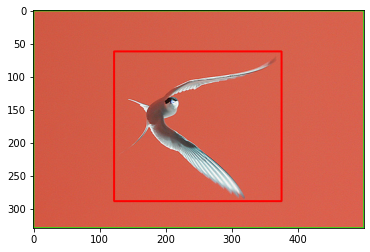

In [111]:
check_bbox('../Raw_images/bird/Artic_Tern_0032_368286416.jpg' ,[122, 62, 375, 288],[0, 0, 500, 329] )